In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
from pathlib import Path
from config import *
from load_utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_lstm_sl_16
num selection:1 - exp name:4_wheel_system_lstm_forecast_sl_30_run_2
num selection:2 - exp name:third_wheel_lstm_forecast_sl_16_run_1


In [12]:
select_exp = '2'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: third_wheel_lstm_forecast_sl_16_run_1


In [13]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm/third_wheel_lstm_forecast_sl_16_run_1/summary.csv


In [14]:
summary.drop(columns = ['train_loss']).reset_index().head()

,index,Unnamed: 0,name,parameters_number,val_loss
0,29,15,"trainLSTM_1c003_00009_9_batch_size=100,embeddi...",30596,0.068476
1,27,2,"trainLSTM_1c003_00022_22_batch_size=500,embedd...",30596,0.068860
2,28,10,"trainLSTM_1c003_00000_0_batch_size=500,embeddi...",30596,0.068860
3,26,18,"trainLSTM_1c003_00013_13_batch_size=500,embedd...",39044,0.068885
4,25,27,"trainLSTM_1c003_00025_25_batch_size=500,embedd...",63876,0.069025


In [15]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 100, 'embedding_dim': 32, 'epochs': 200, 'lr': 0.0003, 'lr_patience': 5, 'n_layers_cell_1': 1, 'n_layers_cell_2': 1, 'seq_in_length': 30}


In [7]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [8]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [11]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None

df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], 
             transform=transform)    

In [14]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=params_conf["output_size"], embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Encoder(
  (LSTMenc): LSTM(4, 32, batch_first=True)
  (LSTM1): LSTM(32, 16, batch_first=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
)
number of params 8132


In [15]:
compute_mse_val_loss=True

In [17]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
        print(i, np.mean(mse_val_loss_list))
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

0 0.08697476983070374
1 0.08624232932925224
2 0.09979942192633946
3 0.09504608251154423
4 0.08547842502593994
5 0.07677914947271347
6 0.07270113006234169
7 0.06915687443688512
8 0.07222961924142307
9 0.07928597666323185
10 0.08147530833428557
11 0.07920357678085566
12 0.07691186007398826
13 0.07554738356598786
14 0.07390300035476685
15 0.0728917932137847
16 0.07490878990467857
17 0.07609478135903676
18 0.07495683647300068
19 0.07328283470124006
20 0.07119608306813807
21 0.07005197495560754
22 0.06934711069840452
23 0.07078572416988511
24 0.07494068138301373
25 0.07446899085950393
26 0.0736855156029816
27 0.07269382084320698
28 0.07180109729283843
29 0.07070576902478934
30 0.06999447346935349
31 0.07232499244855717
32 0.07364120769004028
33 0.07306433912804898
34 0.07200279581759657
35 0.07107913840769066
36 0.07060264136541534
37 0.06989874048648696
38 0.07108081480822502
39 0.07294532717205585
40 0.0728165862127775
41 0.07227074581065349
42 0.07139898121876773
43 0.07093786511739547
4

KeyboardInterrupt: 

In [10]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160
random shift 125044


In [12]:
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                     sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                             , shift = None)

time horizon 160
random shift 48422


In [14]:
yo = model(x.to(device))

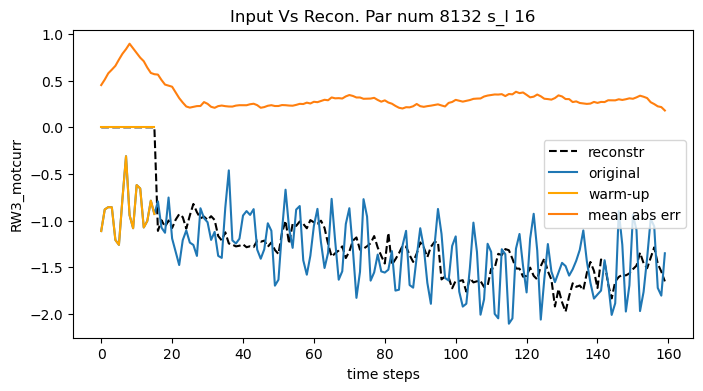

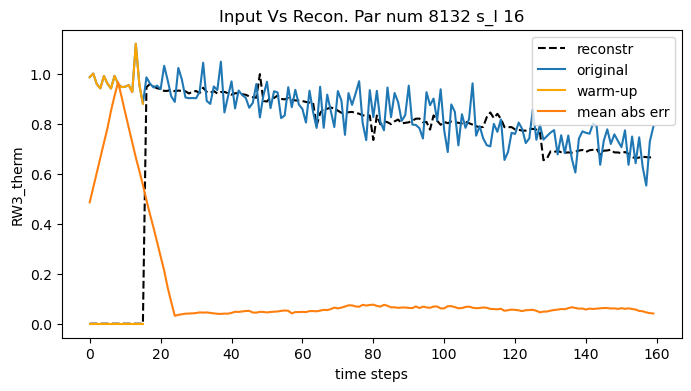

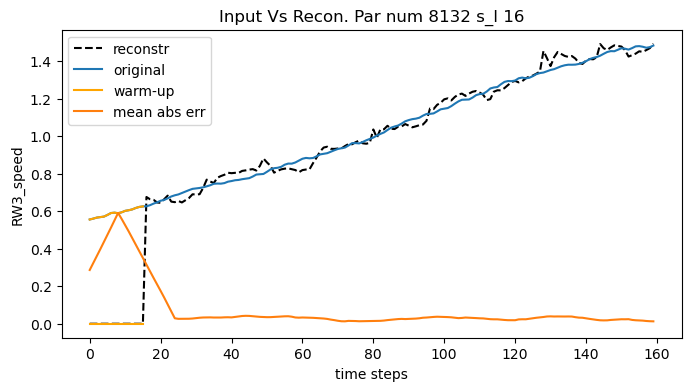

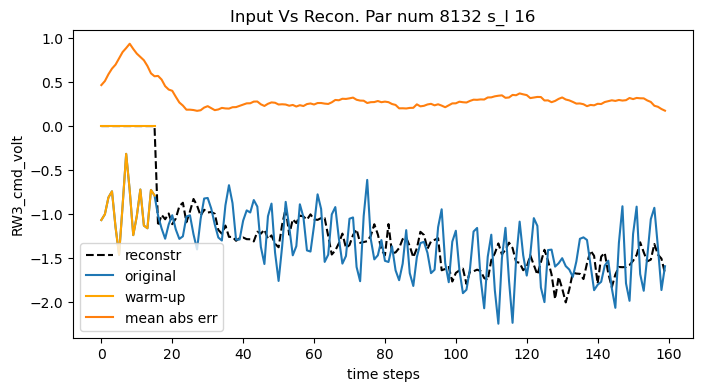

In [15]:
show_results(x.to(device),yo,cfg.dataset.columns,
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)